In [5]:
import os
import requests

def save_and_cache(url, path, force=False):
    if not os.path.exists(path) or force:
        print(f"Downloading {url} to {path} ...")
        r = requests.get(url)
        with open(path, 'wb') as f:
            f.write(r.content)

   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.8 MB 640.0 kB/s eta 0:00:06
   - -------------------------------------- 0.1/3.8 MB 1.4 MB/s eta 0:00:03
   --- ------------------------------------ 0.4/3.8 MB 2.9 MB/s eta 0:00:02
   ------- -------------------------------- 0.7/3.8 MB 4.1 MB/s eta 0:00:01
   ----------- ---------------------------- 1.1/3.8 MB 5.1 MB/s eta 0:00:01
   -------------- ------------------------- 1.4/3.8 MB 5.8 MB/s eta 0:00:01
   ------------------ --------------------- 1.7/3.8 MB 5.5 MB/s eta 0:00:01
   -------------------------- ------------- 2.5/3.8 MB 7.1 MB/s eta 0:00:01
   --------------------------- ------------ 2.7/3.8 MB 7.3 MB/s eta 0:00:01
   ---------------------------------------  3.7/3.8 MB 8.3 MB/s eta 0:00:01
   ---------------------------------------- 3.8/3.8 MB 8.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 疫情数据

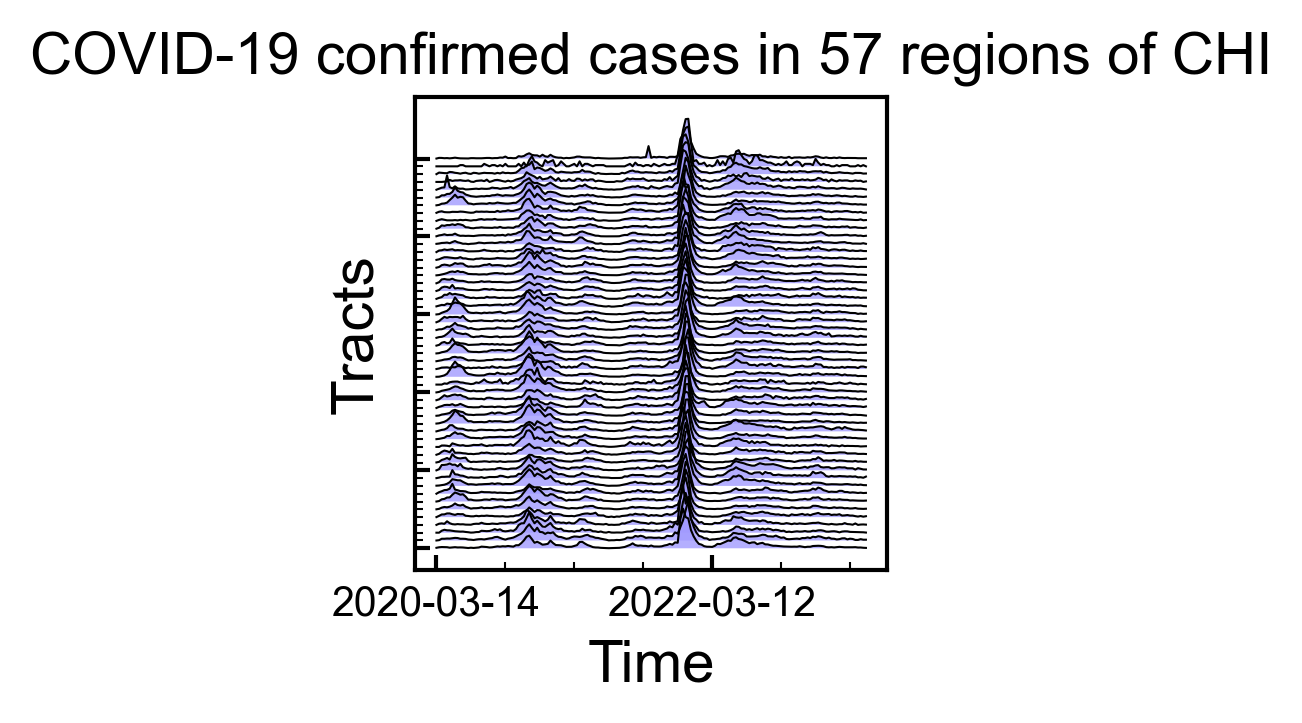

(57,) (163,) (163, 57)


In [6]:
import numpy as np
import pandas as pd

# see https://catalog.data.gov/dataset/covid-19-cases-tests-and-deaths-by-zip-code for more information
save_and_cache('https://data.cityofchicago.org/api/views/yhhz-zm2v/rows.csv?accessType=DOWNLOAD', '../data/epidemic/COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code_-_Historical.csv')
df = pd.read_csv('../data/epidemic/COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code_-_Historical.csv', comment='#')
df = df[df['ZIP Code'] != 'Unknown']
df['Week End'] = pd.to_datetime(df['Week End'], format='%m/%d/%Y')
df = df.pivot_table(index='Week End', columns='ZIP Code', values='Cases - Weekly').fillna(0.0)
df = df.iloc[:163]

## 将 60601, 60602, 60603, 60604, 60606 合并为 60601
# df['60601'] = df[['60601', '60602', '60603', '60604', '60606']].sum(axis=1)
# df = df.drop(columns=['60602', '60603', '60604', '60606'])

# 将 60602, 60604, 60606 合并为 60606
df['60606'] = df[['60602', '60604', '60606']].sum(axis=1)
df = df.drop(columns=['60602', '60604'])

time = df.index.astype(str).values # (T,)
node = df.columns.values # (N,)
case = df.values # (T, N)

import matplotlib.pyplot as plt
from ND2.utils import get_fig, clear_svg
fi, fig, axes = get_fig(1, 1, AW=4, AH=4, lw=1.0, fontsize=14)

N = 51 # len(node)
dN = 10
dT = 52 * 2
delta = -1
for idx, name in enumerate(node[:N]):
    scale = N / 10 / case[:, idx].max()
    axes[0].plot(case[:, idx] * scale + delta*idx, color='black', lw=fi.lw/2)
    axes[0].fill_between(np.arange(len(time)), case[:, idx] * scale + delta*idx, delta*idx, color='#a29bfe', alpha=0.8, edgecolor=None)
axes[0].set_xticks(np.arange(len(time))[::dT])
axes[0].set_xticks(np.arange(len(time))[::dT//4], minor=True)
axes[0].set_xticklabels(time[::dT], rotation=0, fontsize=0.7*fi.fontsize)
axes[0].set_xlabel('Time', fontsize=fi.fontsize)

axes[0].set_yticks(delta*np.arange(len(node))[:N:dN])
axes[0].set_yticks(delta*np.arange(len(node))[:N], minor=True)
axes[0].tick_params(axis='both', which='minor', width=fi.lw/2)
# axes[0].set_yticklabels(node[:N:dN], fontsize=0.7*fi.fontsize)
axes[0].set_yticklabels([], fontsize=fi.fontsize)
axes[0].set_ylabel('Tracts', fontsize=fi.fontsize)

axes[0].tick_params(axis='both', which='both', direction='in')
axes[0].set_title(f'COVID-19 confirmed cases in {len(node)} regions of CHI', fontsize=fi.fontsize)
fig.savefig('../plot/epidemic/COVID19inCHI.png', dpi=300, transparent=True)
fig.savefig('../plot/epidemic/COVID19inCHI.svg', transparent=True)
clear_svg('../plot/epidemic/COVID19inCHI.svg')
plt.show()

print(node.shape, time.shape, case.shape)

In [7]:
node

array(['60601', '60603', '60605', '60606', '60607', '60608', '60609',
       '60610', '60611', '60612', '60613', '60614', '60615', '60616',
       '60617', '60618', '60619', '60620', '60621', '60622', '60623',
       '60624', '60625', '60626', '60628', '60629', '60630', '60631',
       '60632', '60633', '60634', '60636', '60637', '60638', '60639',
       '60640', '60641', '60642', '60643', '60644', '60645', '60646',
       '60647', '60649', '60651', '60652', '60653', '60654', '60655',
       '60656', '60657', '60659', '60660', '60661', '60666', '60707',
       '60827'], dtype=object)

In [8]:
len(node)

57

# 移动数据

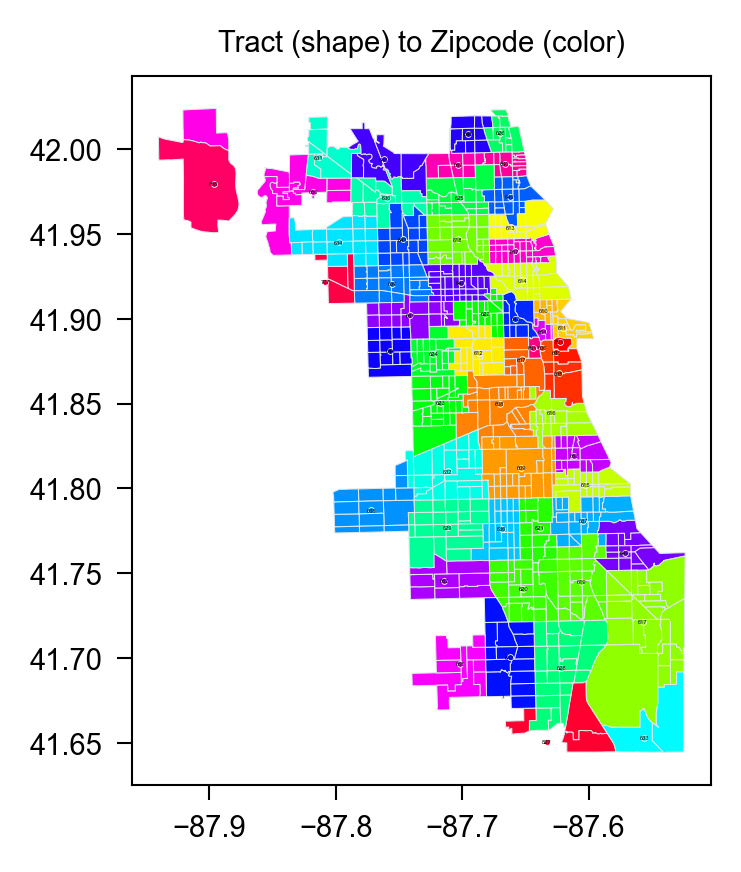

In [13]:
# Crosswalk
import geopandas as gpd
# see https://proximityone.com/ziptractequiv.htm#table for more information
save_and_cache('https://proximityone.com/countytrends/zip2tract2020.csv', '../data/epidemic/zip2tract2020.csv')
df = pd.read_csv('../data/epidemic/zip2tract2020.csv', names=['ZIPCode', 'St', 'StCity', 'Tract', 'TractGeoID', 'CtyName', 'ZIPName', 'Pop 2020', 'Part Pct'], encoding='latin1')
df['ZIPCode'] = df['ZIPCode'].astype(str)
df['TractGeoID'] = df['TractGeoID'].astype(str)
tract2zip = {}
for tract, group in df.groupby('TractGeoID'):
    idx = group['Part Pct'].argmax()
    tract2zip[tract] = group.iloc[idx]['ZIPCode']
update = {
    '17031841400':'60623',
    '17031835900':'60653',
    '17031841600':'60623',
    '17031835700':'60609', # 60615
    '17031330100':'60605', # 60616
    '17031380700':'60653', # 60609
    '17031380500':'60609', # 60653
    '17031460600':'60617', # 60649
    '17031460700':'60617', # 60649
    '17031490300':'60619', # 60628
    '17031490400':'60619', # 60628
    '17031611000':'60609',
    '17031611100':'60609',
    '17031630200':'60632', # 60609
    '17031630100':'60632', # 60609
    '17031770902':'60656',
    '17031823304':'60655',
    '17031810400':'60656',
    '17031770602':'60656',
    '17031980000':'60666',
    '17031280100':'60661', # 60606
    '17031320100':'60601',
    '17031320102':'60606', # 60602
}
tract2zip.update(update)

# Visualization
# See https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik for more information
save_and_cache('https://data.cityofchicago.org/api/geospatial/5jrd-6zik?method=export&format=Shapefile', '../data/epidemic/Boundaries - Census Tracts - 2010.zip')
gdf = gpd.read_file('../data/epidemic/Boundaries - Census Tracts - 2010.zip')

gdf['zipcode'] = gdf['geoid10'].map(tract2zip).fillna('Unknown')

from ND2.utils.plot import get_fig
fi, fig, axes = get_fig(1, 1, AW=6, AH=6)
zip2color = {zipcode: plt.cm.hsv(idx/len(node)) for idx, zipcode in enumerate(node)}
color = []
for idx, row in gdf.iterrows():
    if row['zipcode'] in node:
        color.append(zip2color[row['zipcode']])
    elif row['zipcode'] == 'Unknown':
        color.append((0.0, 0.0, 0.0, 1.0))
    else: # zipcode not in node
        color.append((0.5, 0.5, 0.5, 1.0))
gdf.plot(ax=axes[0], color=color, edgecolor='#dfe6e9', lw=fi.lw/2)

axes[0].set_title('Tract (shape) to Zipcode (color)')

df = pd.read_csv('../data/epidemic/COVID-19_Cases__Tests__and_Deaths_by_ZIP_Code_-_Historical.csv', comment='#')
df = df[['ZIP Code', 'ZIP Code Location']].drop_duplicates()
for zipcode in node:
    color = zip2color[zipcode]
    if zipcode not in df['ZIP Code'].values:
        print(f"{zipcode} not in df['ZIP Code']")
        continue
    x, y = df[df['ZIP Code'] == zipcode]['ZIP Code Location'].values[0].removeprefix('POINT (').removesuffix(')').split(' ')
    x, y = float(x), float(y)
    axes[0].scatter([x], [y], s=2, color=color, edgecolor='white', linewidths=0.2)
    axes[0].text(x, y, zipcode[2:], fontsize=0.2*fi.fontsize, color='black', ha='center', va='center')

In [336]:
# df = pd.read_csv('../data/zip2tract2020.csv', names=['ZIPCode', 'St', 'StCity', 'Tract', 'TractGeoID', 'CtyName', 'ZIPName', 'Pop 2020', 'Part Pct'], encoding='latin1')
# df[df['ZIPCode'] == 60606]

ZIPCode  St  StCity   Tract   TractGeoID  CtyName      ZIPName  \
42412    60606  IL   17031  2801.0  17031280100  Cook IL  Chicago, IL   
42418    60606  IL   17031  2819.0  17031281900  Cook IL  Chicago, IL   
43767    60606  IL   17031  8391.0  17031839100  Cook IL  Chicago, IL   

       Pop 2020  Part Pct  
42412      1551    0.4085  
42418       348    0.0917  
43767      1898    0.4999

In [152]:
# gdf[gdf['zipcode'] == 'Unknown']['geoid10'].tolist()
# gdf[~gdf['zipcode'].isin(list(node))]['geoid10'].tolist()

['17031770602', '17031770902', '17031823304', '17031810400', '17031980000']

In [198]:
# df = pd.read_csv('../data/zip2tract2020.csv', names=['ZIPCode', 'St', 'StCity', 'Tract', 'TractGeoID', 'CtyName', 'ZIPName', 'Pop 2020', 'Part Pct'], encoding='latin1')
# df[df['TractGeoID'].astype(str).str.startswith('17031320') & df['ZIPCode'].astype(str).isin(list(node))]

ZIPCode  St  StCity    Tract   TractGeoID  CtyName      ZIPName  \
42459    60601  IL   17031  3201.01  17031320101  Cook IL  Chicago, IL   
42460    60601  IL   17031  3201.02  17031320102  Cook IL  Chicago, IL   
42461    60602  IL   17031  3201.02  17031320102  Cook IL  Chicago, IL   
42462    60602  IL   17031  3204.00  17031320400  Cook IL  Chicago, IL   
42463    60603  IL   17031  3204.00  17031320400  Cook IL  Chicago, IL   
42464    60604  IL   17031  3204.00  17031320400  Cook IL  Chicago, IL   
42465    60605  IL   17031  3204.00  17031320400  Cook IL  Chicago, IL   
42466    60605  IL   17031  3206.00  17031320600  Cook IL  Chicago, IL   

       Pop 2020  Part Pct  
42459      9532    0.6028  
42460      3925    0.2482  
42461       921    0.7304  
42462        70    0.0555  
42463       947    0.7352  
42464       616    0.6867  
42465      1223    0.0359  
42466      6395    0.1877

In [14]:
import pandas as pd

# https://lehd.ces.census.gov/data/ 提供的 OD 数据，参考 https://lehd.ces.census.gov/data/lodes/LODES8/LODESTechDoc8.1.pdf
save_and_cache('https://lehd.ces.census.gov/data/lodes/LODES8/il/od/il_od_main_JT00_2020.csv.gz',
                '../data/epidemic/il_od_main_JT00_2020.csv.gz')
df = pd.read_csv('../data/epidemic/il_od_main_JT00_2020.csv.gz', compression='gzip')
# 15-digits BLOCK CODE (state(2), country(3), tract(6), block(4)) -> 11-digits TRACT CODE
df['w_zipcode'] = df['w_geocode'].astype(str).str.slice(0, 11).map(tract2zip)
df['h_zipcode'] = df['h_geocode'].astype(str).str.slice(0, 11).map(tract2zip)

# 排除没有有效的 MODZCTA 信息的记录
tmp = df.copy()
df.dropna(subset=['w_zipcode', 'h_zipcode'], inplace=True)
print(f'Filtered {len(tmp) - len(df)} records with missing ZIPCode information, keeping {len(df)/len(tmp):%} records')

df = df[['w_zipcode', 'h_zipcode', 'S000']]
df.columns = ['source', 'destination', 'flow']
# 汇总
df = df.groupby(['source', 'destination']).sum().reset_index()
# 排除自己到自己的流量
df = df[df['source'] != df['destination']]
# 排除不在 node 中的记录
df = df[df['source'].isin(node) & df['destination'].isin(node)]
assert all(np.sort(df['source'].unique()) == np.sort(df['destination'].unique()))
for i in node: assert i in df['source'].unique(), i

df

Filtered 126 records with missing ZIPCode information, keeping 99.997426% records


source destination  flow
118916  60601       60603    21
118917  60601       60605   204
118918  60601       60606   129
118919  60601       60607   198
118920  60601       60608   106
...       ...         ...   ...
150712  60827       60655    25
150713  60827       60656     1
150714  60827       60657     1
150715  60827       60661     2
150716  60827       60707     4

[3138 rows x 3 columns]

In [15]:
a = set(df['source'].unique())
b = set(df['destination'].unique())
c = set(node)

print(a == b)
print(a - c, c - a)

True
set() set()


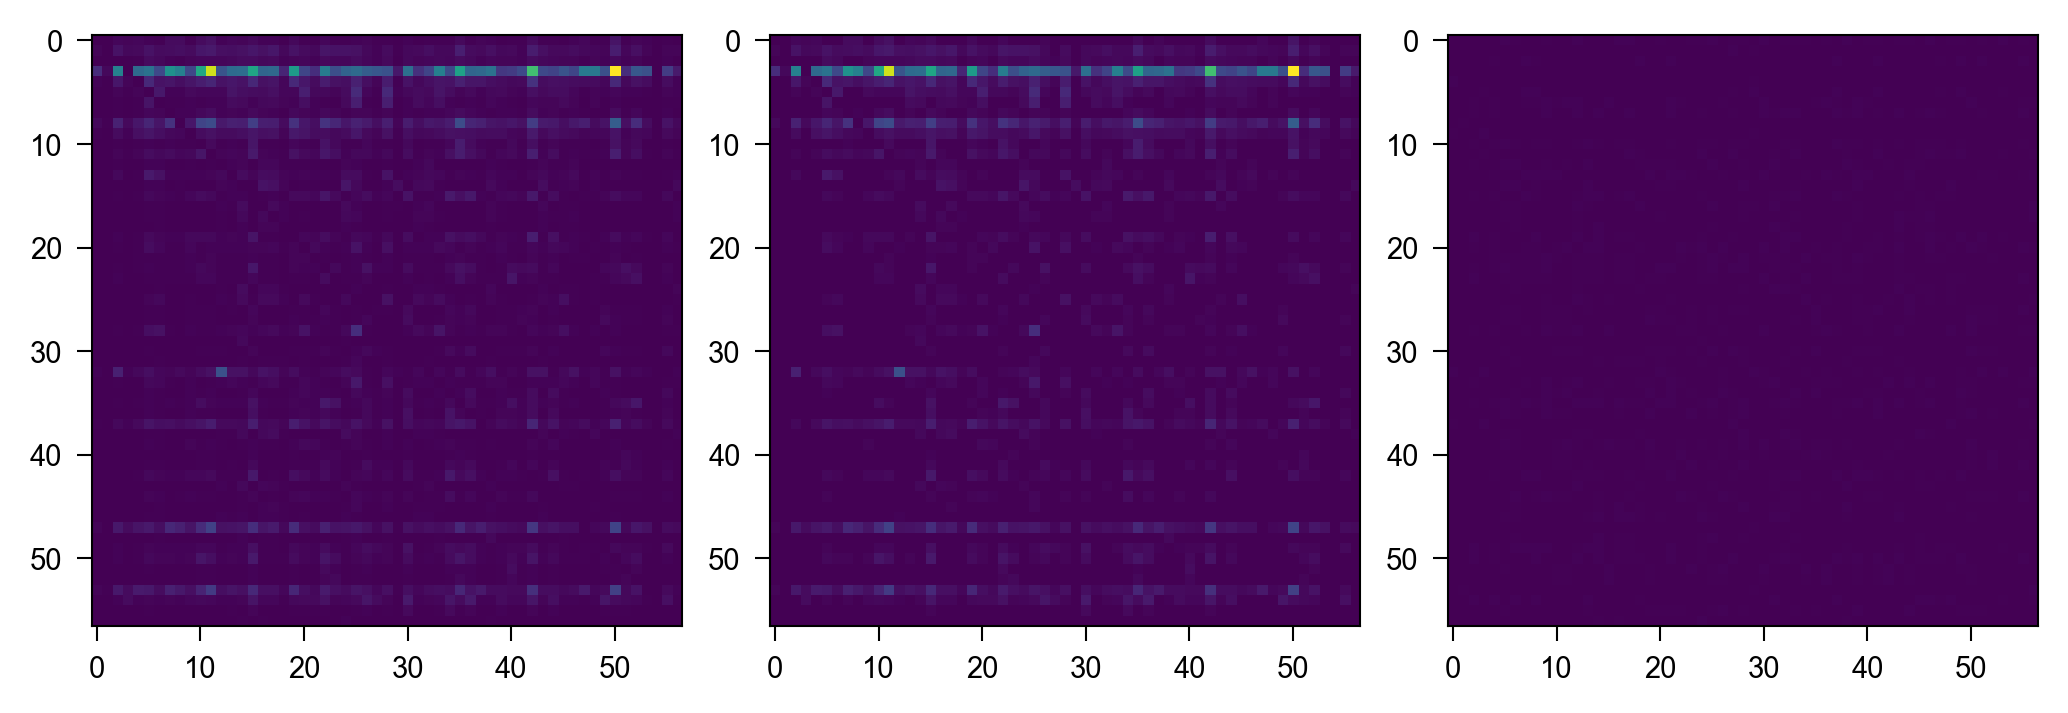

In [17]:
D = 20
df_sparse = df.copy()
df_sparse.sort_values('flow', ascending=False, inplace=True)
df_sparse = df_sparse[:D*len(node)]
df_sparse

from ND2.utils import get_fig
from matplotlib.colors import LogNorm, Normalize
fi, fig, axes = get_fig(1, 3, AW=5)
norm = Normalize(vmin=0, vmax=df['flow'].max())
pivot1 = df.pivot_table(index='source', columns='destination', values='flow', fill_value=0, aggfunc='sum').reindex(index=node, columns=node, fill_value=0)
pivot2 = df_sparse.pivot_table(index='source', columns='destination', values='flow', fill_value=0, aggfunc='sum').reindex(index=node, columns=node, fill_value=0)
axes[0].imshow(pivot1.values, norm=norm)
axes[1].imshow(pivot2.values, norm=norm)
axes[2].imshow(pivot1.values - pivot2.values, norm=norm)
plt.show()

In [9]:
df_sparse

source destination   flow
120811  60606       60657  10728
120772  60606       60614   9947
120803  60606       60647   7465
120771  60606       60613   6431
120776  60606       60618   6290
...       ...         ...    ...
140008  60646       60631    119
135497  60637       60654    119
132410  60629       60621    119
134783  60634       60651    119
129566  60622       60645    119

[1140 rows x 3 columns]

In [10]:
gdf

commarea  commarea_n countyfp10      geoid10 name10         namelsad10  \
0         44        44.0        031  17031842400   8424  Census Tract 8424   
1         59        59.0        031  17031840300   8403  Census Tract 8403   
2         34        34.0        031  17031841100   8411  Census Tract 8411   
3         31        31.0        031  17031841200   8412  Census Tract 8412   
4         32        32.0        031  17031839000   8390  Census Tract 8390   
..       ...         ...        ...          ...    ...                ...   
796        7         7.0        031  17031070400    704   Census Tract 704   
797        7         7.0        031  17031070500    705   Census Tract 705   
798       13        13.0        031  17031130300   1303  Census Tract 1303   
799       29        29.0        031  17031292200   2922  Census Tract 2922   
800       63        63.0        031  17031630900   6309  Census Tract 6309   

    notes statefp10 tractce10  \
0    None        17    842400   
1    None        17    840300   
2    None        17    841100   
3    None        17    841200   
4    None        17    839000   
..    ...       ...       ...   
796  None        17    070400   
797  None        17    070500   
798  None        17    130300   
799  None        17    292200   
800  None        17    630900   

                                              geometry zipcode  
0    POLYGON ((-87.62405 41.73022, -87.62405 41.730...   60620  
1    POLYGON ((-87.68608 41.82296, -87.68607 41.823...   60608  
2    POLYGON ((-87.62935 41.8528, -87.62934 41.8525...   60616  
3    POLYGON ((-87.68813 41.85569, -87.68816 41.856...   60608  
4    POLYGON ((-87.63312 41.87449, -87.63306 41.874...   60605  
..                                                 ...     ...  
796  POLYGON ((-87.65746 41.93258, -87.65722 41.932...   60614  
797  POLYGON ((-87.66349 41.93036, -87.6635 41.9306...   60614  
798  POLYGON ((-87.71436 41.983, -87.71472 41.98299...   60659  
799  POLYGON ((-87.71317 41.85523, -87.71357 41.855...   60623  
800  POLYGON ((-87.71129 41.7934, -87.7109 41.79341...   60629  

[801 rows x 11 columns]

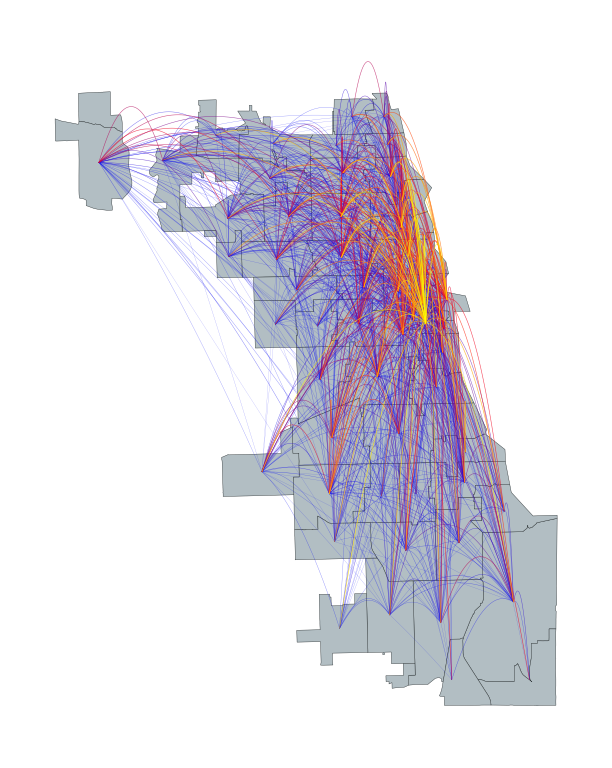

In [19]:
from shapely.ops import unary_union
from ND2.utils.plot import get_fig, plotOD

data = df_sparse
data.columns = ['source', 'destination', 'flow']
coor = [(zipcode, unary_union(group['geometry'])) for zipcode, group in gdf.groupby('zipcode')]
coor = gpd.GeoDataFrame(coor, columns=['NAME', 'geometry'], crs=gdf.crs)

fi, fig, axes = get_fig(1, 1, AW=3*2, A_ratio=1, LM=0, RM=0, BM=0, TM=0.0, lw=1.0, fontsize=14)
coor.plot(ax=axes[0], color='#b2bec3', edgecolor='#2d3436', linewidth=0.1)
location = {row['NAME']: row['geometry'].centroid.coords[0] for _, row in coor.iterrows()}
plotOD(axes[0], data['source'], data['destination'], data['flow'], location, linetype='parabola')
axes[0].axis('off')
fig.savefig('../plot/epidemic/ODinCHI.png', dpi=600, transparent=True)
fig.savefig('../plot/epidemic/ODinCHI.svg', transparent=True)

Drawing MODZCTA Boundaries: 100%|██████████| 57/57 [00:00<00:00, 1540.55it/s]


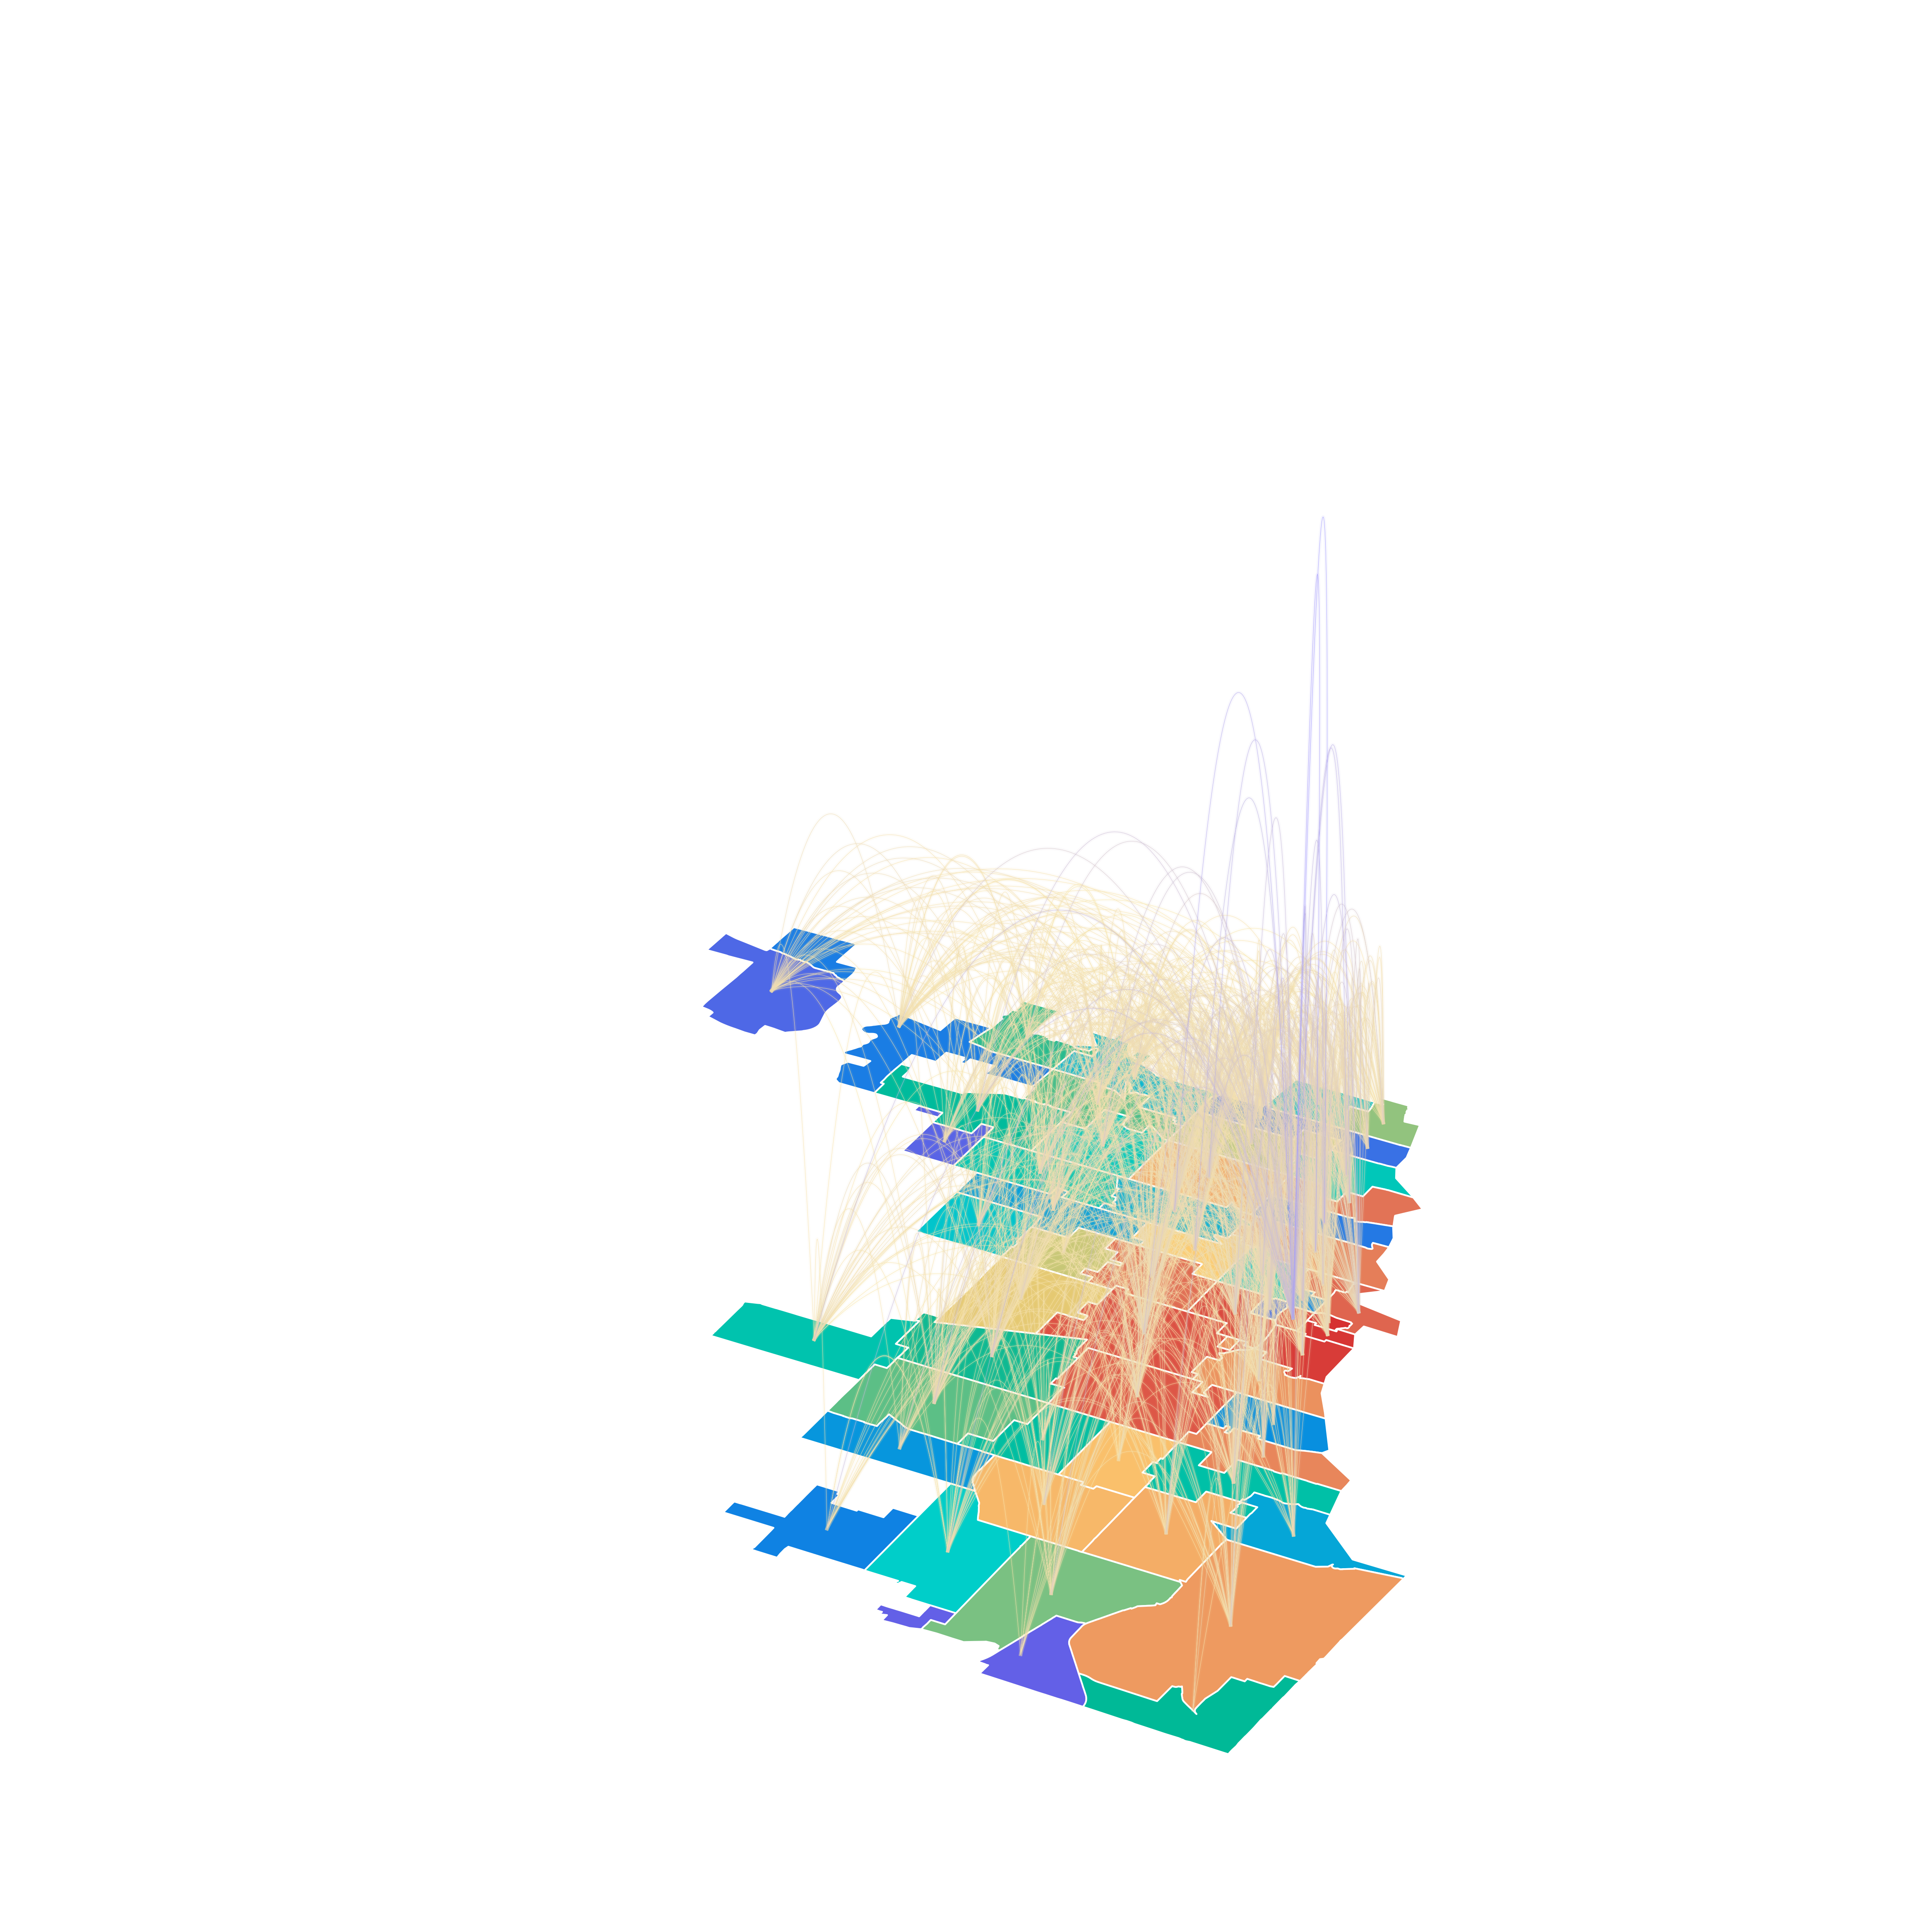

In [20]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure(figsize=(12, 8), dpi=600)
ax = fig.add_subplot(111, projection='3d')

# 绘制 OD 线路
center_dict = {row['NAME']:row['geometry'].centroid.coords[0] for _, row in coor.iterrows()}
myhot = LinearSegmentedColormap.from_list('myhot', ['#ffeaa7', '#a29bfe'], gamma=0.6)
norm = Normalize(vmin=0, vmax=data['flow'].max())
for idx, row in tqdm(data.iterrows(), total=len(data), desc='Drawing OD Flow'):
    x1, y1 = center_dict[row['source']]
    x2, y2 = center_dict[row['destination']]
    if x1 == x2 and y1 == y2: continue
    height = 0.1 * (row['flow'] + 0.3 * data['flow'].max())  # 根据流量设置高度，可以调整比例
    t = np.linspace(0, 1, num=100)
    x = x1 + (x2 - x1) * t
    y = y1 + (y2 - y1) * t
    z = height * 4 * t * (1 - t)  # 抛物线方程
    ax.plot(x, y, z, color=myhot(norm(row['flow'])), linewidth=1.0, zorder=10000+row['flow'], alpha=0.08)
    ax.plot(x, y, z, color=myhot(norm(row['flow'])), linewidth=0.1, zorder=10000+row['flow'], alpha=1.0)

ax.set_xlim(*ax.get_xlim()) # fix aspect ratio
ax.set_ylim(*ax.get_ylim())

# 绘制区域
myhsv = LinearSegmentedColormap.from_list('myhsv', ['#d63031', '#e17055', '#fdcb6e', '#00b894', '#00cec9', '#0984e3', '#6c5ce7'])
norm = Normalize(vmin=0, vmax=len(coor))
for idx, row in tqdm(coor.iterrows(), total=len(coor), desc='Drawing MODZCTA Boundaries'):
    if row['geometry'].geom_type == 'Polygon':
        x, y = row['geometry'].exterior.xy
        poly_collection = Poly3DCollection([list(zip(x, y, [0]*len(x)))], color=myhsv(norm(idx)), zorder=10, linewidth=0.5, edgecolor='white')
        ax.add_collection3d(poly_collection)
    elif row['geometry'].geom_type == 'MultiPolygon':
        for polygon in row['geometry'].geoms:
            x, y = polygon.exterior.xy
            poly_collection = Poly3DCollection([list(zip(x, y, [0]*len(x)))], color=myhsv(norm(idx)), zorder=10, linewidth=0.5, edgecolor='white')
            ax.add_collection3d(poly_collection)

# 设置视角和标签
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# ax.set_title('OD Flow')
ax.axis('off')

# X = np.linspace(*ax.get_xlim(), 10)
# Y = np.linspace(*ax.get_ylim(), 10)
# X, Y = np.meshgrid(X, Y)
# Z = np.zeros_like(X)
# ax.plot_surface(X, Y, Z, zorder=0, color='#000034', alpha=0.1)

# ax.set_facecolor('lightblue')
fig.tight_layout()

plt.show()

# 保存数据

In [21]:
import json

node2idx = {n:idx for idx, n in enumerate(node)}
df_sparse['source_idx'] = df_sparse['source'].map(node2idx)
df_sparse['destination_idx'] = df_sparse['destination'].map(node2idx)
G = df_sparse[['source_idx', 'destination_idx']].values
A = np.zeros((len(node), len(node),), dtype=int)
A[G[:, 0], G[:, 1]] = 1

save = {}
save['node'] = node.tolist() # (N=177,)
save['time'] = time.tolist() # (T=232,)
save['case'] = case.tolist() # (T=232, N=177)
save['flow'] = df_sparse['flow'].tolist() # (E=3540,)
save['A'] = A.tolist() # (N=177, N=177)
save['G'] = G.tolist() # (E=3540, 2)
with open('../data/epidemic/COVID19inCHI.json', 'w') as f:
    json.dump(save, f)

for key, value in save.items():
    print(f'{key:10} -> {np.array(value).shape}')

node       -> (57,)
time       -> (163,)
case       -> (163, 57)
flow       -> (1140,)
A          -> (57, 57)
G          -> (1140, 2)
